# Global sensitivity

The goal of this notebook is to showcase 2 functions, one that implements sensitivity based on the unbounded differential privacy (DP) definition, and another that implements sensitivity based on a bounded definition.
I am not aiming for efficiency but for a deeper understanding of how to implement sensitivity empirically from scratch.

Before continuing there needs to be some clarifications:
In bounded DP, the neighboring dataset is built by changing the records of the dataset (not adding to removing records). E.g. x = {1, 2, 3} (|x|=3) with universe X = {1, 2, 3, 4}, a neighboring dataset in this case would be: x' = {1, 2, 4} (|x'| = 3). They have the same cardinality.
In unbounded DP definition, the neighboring dataset is built by adding ot removing records. E.g. x = {1, 2, 3} (|x| = 3) with universe X = {1, 2, 3, 4}, a neighboring dataset in this case could be: x' = {1, 2} or {1, 3} or {1, 2, 3, 4} (|x|=2 or |x|=2 or |x|=4, but not |x|=3). Their cardinality differs by 1.
The datasets considered are multisets, and their cardinality is the sum of the multiplicities of each value they contain.
The neighboring datasets are also multisets and are considered neighbors if the hamming distance concerning the original dataset is of value k. This parameter is set by the data scientist, but the original definition of DP has a value of k=1 (used for the previous examples).

The hamming distance can be seen as the cardinality of the symmetric difference between 2 datasets. With this in mind, the definition of DP can be written as:

P(M(x) = O) = P(M(x') = O) * exp(epsilon * |x ⊖ x'|)

Where M is a randomized computation, x a dataset, x' its neighbor at hamming distance k = |x ⊖ x'|, and O an output of M given x and x'. 

k is usually 1, to the best of my knowledge, because one aims to protect one individual in the dataset, and by definition, each individual within would therefore be protected. By making the probabilities of obtaining an output O similar betwen two datasets that differ only only in 1 record, one is successfully cloaking the real value of O and therefore not updating fully the knowledge of the adversary, which if done properly, would still be 50/50 between wich dataset was actually the real one. 

Looking at the defintino of DP, the higher your k, the more you would increase exp(.), which means that the difference between the probabilities to obtain those outputs will be larger, and thus your privacy would not be equally conserved (although sensitivities increase with k as you can see in the plots).

I have not come across an intuition for having a larger hamming distance (please feel free to [connect](https://www.linkedin.com/in/gonzalo-munilla/) if you have an explanation). Looking at the previous paragraph, it would seem as if having a hamming distance of k=2 would aim to protect pairs of records (individuals), i.e. it accounts for the fact that there are dependencies between records in the dataset that need to be considered as they increase the probability ratio (undesirable). It could make sense if there are some binary relationship between records, e.g. pairs of siblings, or n-ary relationships for k=n, e.g. in a social network. 

I am however far from certain of my hypothesis for the intuition behind a larger hamming distance.

**Contributions**:
1. I programmed a function that calculates the bounded and unbounded sensitivity of a dataset formed by numeric columns- Additionally, it allows you to vary the hamming distance. Its empirical nature will not allow it to scale well, i.e., the function creates all possible neighboring datasets, with k less or more records (for unbounded DP) and with the same amount of records but changing k values (bounded DP). Where k is the hamming distance. The function calculates the query result for each possible neighboring dataset, then calculates all possible L1 norms, and then chooses the maximum. That will be the sensitivity defined in DP.
2. The sensitivity can be calculated for most of the basic queries: mean, median, percentile, sum, var, std, count*.

I have differentiated between 2 cases:
1. (a) The universe of possible values is based on a dataset, and the size of the released dataset is known before release, i.e. the cardinality of the universe subset. This scenario could be e.g. releasing a study based on some students out of all the students at a school. (Note: the dataset to be released cannot be larger than the dataset used for the universe, only equal or smaller).
2. (b) The universe of possible values is based on a range of values, and the size of the released dataset is known before release. A range is used because the exact values that could potentially be released are not known in advance, thus a range where those values could fall into must be used to perform the sensitivity calculation. This scenario could be e.g. releasing real-time DP results from an IoT device. 
We assume that the size of the released dataset is known, i.e. we know there are n amount of records being queried or from which a synopsis (statistical summary) will be made. This is safe to assume as the number of users or IoT devices in an application can be designed to be known*.
For simplicity, from now on, I will call the datasets D_universe_a and _b, D_release_a and _b, and D_neighbor for (a) and (b).

Note that this is somewhat different from the online (on) (or interactive) and the offline (off) (or non-interactive) definition that [C. Dwork](https://www.cis.upenn.edu/~aaroth/Papers/privacybook.pdf) introduces in her work. These deal with not knowing or knowing the queries beforehand, respectively. But, we could have the case (a) and case (b) in both (on) or (off):
1. Scenario (a) + (on): API that allows external entities to query in a DP manner a subset of the school dataset you host internally (or its entirety).
2. Scenario (a) + (off): Release externally a DP synopsis (statistical summary) of a subset of the school dataset you host internally (or its entirety).
3. Scenario (b) + (on): API that allows external entities to query in a DP manner a dataset updated in real-time by IoT devices hosted internally or decentrally.
4. Scenario (b) + (off): Release externally a DP synopsis of a dataset updated in real-time by IoT devices hosted internally or decentrally.

For this notebook, we will consider Scenario (a) + (off) and (b) + (off).

Also note that (a) and (b) is also somewhat different to local DP (LDP) (DP applied on the device, usually randomized response) versus global DP (GDP) (the third party trusted with all the data, allows for other algorithms). This notebook is focused on GDP. So we have (a) + (off) + (GDP) and (b) + (off) + (GDP). 

Mean questions for clarification: 
- How can (b) and (GDP) go together? The third-party can host a server to process real-time data. 
- Then, why does not the third party aggregate this real-time data and do (a) instead of (b)? It could, but because your dataset is ever-growing, you would need to compute sensitivities every time your dataset would change, which is in real-time, that can be computationally inefficient. 
- But still, you could do (a), right? You could, but you would have to release data over a defined period and release a synopsis aggregating these data. Thus, your service would not be as close to real-time anymore as it would be with (b). But definitively, it is a question to further investigate.
- So what is the major benefit of (b)? You do not need to re-compute your sensitivities, the drawback is that if your domain of possible values is very large then your noise will be larger. In (a) your universe might not contain such wide possible ranges, so it benefits your accuracy. But you can also fine-tune your range in D_universe_b based on an older sample of D_release_b. **But definitively you would like to calculate your sensitivities in case b with an upper bound found theoretically, as finding it empirically is computationally expensive.** You could do the same for case (a), but there is the possibility to find a much better result via calculating its exact global sensitivity. 
- Mmm, and what if you do not know the full domain of your universe? That is indeed a good question. Well, then you will have to do some clipping to not get any surprises. E.g., if you defined your universe like D_universe_b = {'Age': [1, 2, ..., 99, 100]}, but you get a value in real-time like [122](https://en.wikipedia.org/wiki/List_of_the_verified_oldest_people), then you should do top-coding, 122->100, so you can include its value. Outliers and DP do not go well. You can protect them, but the cost would be too high (higher noise), and why would you do that? DP allows you to perform statistical queries, the mean or the sum would not be representative of the population if there are outliers in it. DP is used to learn from a population, not from outliers, if you would like to learn about outliers, then DP is not for you. 

The main difference in this notebook between scenario a and b (aside from the one mentioned), is programmatic: How you define the universe to input into the functions. The functions I created (for the sensitivities in unbounded and bounded DP) serve both scenarios. But in scenario b, aside from the fact that you have only a range of values, to calculate the sensitivity, you have to make as many replicates of each value of the universe as the size of the released dataset. Why? Because if you define your range like e.g. D_universe_b = {'Age': [1, 2, ..., 99, 100]} and with a |D_release| = 4, you could on real-time get a D_release_b={'Age':[100,100,100,100]} or another like D_release_b={'Age':[35, 35, 35, 35]}.

Something to also note is that the functions that calculate the sensitivities only need a universe and the size of the released dataset (together with the hamming distance). They do not need the actual release dataset, which could be a possibility.

Limitations:
1. The functions to calculate sensitivity do not scale well in terms of the size of your universe
2. *****The count query sensitivity should be 1 for unbounded and 2 for bounded DP. The former is clear because you just add or remove one record, increasing or decreasing the total count of the record by one. However, if you have bounded sensitivity, the change of one record might lead to the decrease of the count of one record and the increase of the count of another, yielding a total difference of 2. These 2 cases are not accounted for, we solely count the number of elements in the array, which leads to a sensitivity of 1 in unbounded and of 0 inbounded. To empirically prove the fact that for bounded you have a sensitivity of 2, there needs to be more work done on how the query results are handled, which is a lot of extra workload for obtaining a solution that is already well known.**

***** If the number of users/IoT devices is desired to be protected, then one can take a large sample of records, but not all the records, and the cardinality considered would be the number of the sampled records. Thus an attacker would not know the actual number of users/IoT devices.

## Datasets

In [1]:
# Visualization
%pylab inline
from IPython.display import display, Math, Latex
import matplotlib.pyplot as plt

# handling data
import csv
import json
import pandas as pd

# Math
from random import random
import scipy.stats as ss
import numpy as np
import itertools
from collections import Counter 

Populating the interactive namespace from numpy and matplotlib


### Datasets (a)

We have 2 datsets to test our function:
- (a_s) A small one I can use to benchmark our functions against a published paper ["How much is enough? Choosing epsilon for Differential Privacy"](https://git.gnunet.org/bibliography.git/plain/docs/Choosing-%CE%B5-2011Lee.pdf). Which was implemented in my previous [blog post](https://github.com/gonzalo-munillag/Blog/tree/main/Extant_Papers_Implementations/A_method_to_choose_epsilon).
- (a_l) A large one to test the functions further.

The use case will be records from the students in a school.

###### D_a_small (Dataset for scenario a - small)

In [2]:
# We define the actual dataset (conforming the universe)
D_a_small_universe_dict = {'name': ['Chris', 'Kelly', 'Pat', 'Terry'], 'school_year': [1, 2, 3, 4], 'absence_days': [1, 2, 3, 10]}

In [3]:
D_a_small_universe = pd.DataFrame(D_a_small_universe_dict)
D_a_small_universe

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Pat,3,3
3,Terry,4,10


In [4]:
# We define the the dataset that we will release
D_a_small_release = D_a_small_universe.drop([3], axis=0)
D_a_small_release

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Pat,3,3


The adversary model adopted in the paper mentioned above is the worst-case scenario and it will be the one I adopted in this notebook: An attacker has infinite computation power, and because DP provides privacy given adversaries with arbitrary background knowledge, it is okay to assume that the adversary has full access to all the records (adversary knows all the universe, i.e. D_a_small_universe). But there is a dataset made from the universe without an individual (D_a_small_release), and the adversary does not know who is and who is not in it (this is the only thing the adversary does not know about the universe), but the adversary knows D_a_small_release contains people with a particular quality (the students who have not been in probation). With D_a_small_universe, the attacker will try to reconstruct the dataset he does not know (D_a_small_release) by employing queries on D_a_small_release without having access to it.

###### D_a_large (Dataset for scenario a - large)

The larger dataset for the universe is used to test the functions with a hamming distance >1 and with a universe with duplicated values both in the univese and the release, which does not mean are the same records.

In [5]:
# We define the actual dataset (conforming the universe)
D_a_large_universe_dict = {'name': ['Chris', 'Kelly', 'Keny', 'Sherry', 'Jerry', 'Morty', "Beth", "Summer", "Squanchy", "Rick"], \
                     'school_year': [1, 2, 2, 2, 5, 5, 7, 8, 9, 9], 'absence_days': [1, 2, 3, 4, 5, 6, 7, 8, 15, 20]}

In [6]:
D_a_large_universe = pd.DataFrame(D_a_large_universe_dict)
D_a_large_universe

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Keny,2,3
3,Sherry,2,4
4,Jerry,5,5
5,Morty,5,6
6,Beth,7,7
7,Summer,8,8
8,Squanchy,9,15
9,Rick,9,20


In [7]:
# We define the the dataset that we will release
D_a_large_release = D_a_large_universe.iloc[:6,:]
D_a_large_release

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Keny,2,3
3,Sherry,2,4
4,Jerry,5,5
5,Morty,5,6


### Datasets (b)

There will be only one dataset for scnario b, designed to test the functions with a hammig distance > 1. Notice that I only define the cardinality (number of records in this case) of the release dataset and nothing more. 

We do not use a dataframe for D_b_universe becuase the cardinality of each universe is different.

The use case will be a vehicle sending the mood of the passenger (1 - sad to 2 - happy) and how well he/she drives (0 - terrible to 3 - perfect). (This is just for the sake of the example, categorical values would be more sense). 

Due to the limitations of this manner of calculating sensitivities, I cannot create a large range and length of the release dataset. But then again, I programmed this notebook to understand more deeply sensitivities, and it works alright for a hamming distance of 1, which is most common. 

In [8]:
# We define the actual dataset (conforming the universe)
D_b_release_length = 4
D_b_universe = {'mood': [1, 2], 'driving_proficiency': [1, 2, 3]}

# Because we know the cardinality of the release datase, then:
for key, values in D_b_universe.items():
        
        D_b_universe[key] = values * D_b_release_length

D_b_universe

{'mood': [1, 2, 1, 2, 1, 2, 1, 2],
 'driving_proficiency': [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]}

## Functions

### Auxiliary function

##### Here we have all the queries we could make to the numerical data

In [9]:
# With this funciton, we can make easier to call the mean, median... functions
# REF: https://stackoverflow.com/questions/34794634/how-to-use-a-variable-as-function-name-in-python
# It is not clean to have the var percentile input each function, but it is less verbose than having a function
# For each percentile. We could however limit the maount of percentiles offer to 25 and 75.
class Query_class:  
    """
    A class used to represent a query. YOu instantiate an object that will perform a particlar query on an array

    Attributes
    ----------
    fDic - (dict) containing the possible queries the class can be transformed into
    fActive - (function) it contins the function we created the class to have

    Methods
    -------
    
    run_query - I will run the query for which we instantiated the class
    The other methods implement the different possible queries
    
    """
    
    def __init__(self, fCase):
        
        # mapping: string --> variable = function name
        fDic = {'mean':self._mean,         
                'median':self._median,
                'count': self._count,
                'sum': self._sum,
                'std': self._std,
                'var': self._var,
                'percentile': self._percentile}
        
        self.fActive = fDic[fCase]
    
    # Calculate the mean of an array
    def _mean(self, array, percentile): 

        return np.mean(array)
    
    # Calculate the median of an array
    def _median(self, array, percentile): 
        
        return np.median(array)
            
    # Calculate the number of elements in the array
    def _count(self, array, percentile):
        
        return len(array)
    
    # Calculate the sum of an array
    def _sum(self, array, percentile):
        
        return np.sum(array)
    
    # Calculate the std of an array
    def _std(self, array, percentile):
        
        return np.std(array)
    
    # Calculate the variance of an array
    def _var(self, array, percentile):
        
        return np.var(array)
    
    def _percentile(self, array, percentile):

        return np.percentile(array, percentile)
    
    # It will run the given query
    def run_query(self, array, percentile=50):
        
        return self.fActive(array, percentile)

In [10]:
# Set of checks on the input values
def verify_sensitivity_inputs(universe_cardinality, universe_subset_cardinality, hamming_distance):
    """
    INPUT:
        universe - (df) contains all possible values of the dataset
        universe_subset_cardinality - (df) cardinality of the universe subset
        hamming_distance - (int) hamming distance between neighboring datasets
        
    OUTPUT:
        ValueError - (str) error message due to the value of the inputs
        
    Description:
    It performs multiple checks to verify the validity of the inputs for the calculation of senstitivity
    """

    # Check on unverse cardinality (1). 
    # The cardinality of the subset of the universe cannot be larger than the universe 
    if universe_cardinality < universe_subset_cardinality:

        raise ValueError("Your universe dataset cannot be smaller than your release dataset.")
    
    # Checks on the validity of the chosen hamming_distance (3)
    if hamming_distance >= (universe_subset_cardinality):
        
        raise ValueError("Hamming distance chosen is larger than the cardinality of the release dataset.")

    if (hamming_distance > np.abs(universe_cardinality - universe_subset_cardinality)):
        
        raise ValueError("Hamming distance chosen is larger than the cardinality difference between the \
        universe and the release dataset, i.e., \
        there are not enough values in your universe to create such a large neighboring dataset (Re-sampling records).")
    
    # The hamming distance cannot be 0, then your neighbor dataset is equal to the original dataset
    if hamming_distance == 0:

        raise ValueError("Hamming distance cannot be 0.")

In [11]:
# Used by unbounded unbounded_empirical_global_L1_sensitivity_a
def L1_norm_max(release_dataset_query_value, neighbor_datasets, query, percentile):
    """
    INPUT:
        release_dataset_query_value - (float) query value of a particular possible release dataset
        neighbor_datasets - (list) contains the possible neighbors of the specific release dataset
        query - (object) instance of class Query_class
        percentile - (int) percentile value for the percentile query

        
    OUTPUT:
        L1_norm_maximum - (float) maximum L1 norm calcuated from the differences between the query results 
        of the neighbor datasets and the specific release dataset

    Description:
    It claculates the maximum L1 norm between the query results of the neighbor datasets and the specific release dataset
    """

    neighbor_dataset_query_values = []
    for neighbor_dataset in neighbor_datasets:

        neighbor_dataset_query_value = query.run_query(neighbor_dataset, percentile)
        neighbor_dataset_query_values.append(neighbor_dataset_query_value)

    # We select the maximum and minimum values of the queries, as the intermediate values will not 
    # yield a larger L1 norm (ultimately, we are interested in the maximum L1 norm)
    neighbor_dataset_query_value_min, neighbor_dataset_query_value_max = \
    min(neighbor_dataset_query_values), max(neighbor_dataset_query_values)
    # We calculate the L1 norm for these two values and pick the maximum
    L1_norm_i = np.abs(release_dataset_query_value - neighbor_dataset_query_value_min)
    L1_norm_ii = np.abs(release_dataset_query_value - neighbor_dataset_query_value_max)
    L1_norm_maximum = max(L1_norm_i, L1_norm_ii)
        
    return L1_norm_maximum

In [12]:
def calculate_unbounded_sensitivities(universe, universe_subset_cardinality, columns, hamming_distance, unbounded_sensitivities):
    """
    INPUT:
        universe - (df or dict) contains all possible values of the dataset
        universe_subset_cardinality - (int) contains the length of the subset chosen for the release dataset
        columns - (array) contains the names of the columns we would like to obtain the sensitivity from
        hamming_distance - (int) hamming distance between neighboring datasets
        unbounded_sensitivities - (dict) stores sensitivities per hamming distance and query type
    
    OUTPUT
        unbounded_sensitivities - (dict) stores sensitivities per hamming distance and query type

    Description:
    It calculates the sensitivities for a set of queries given a universe and a release dataset.
    """
    # Calculate the sensitivity of different queries for the unbounded DP
    query_type = 'mean'
    mean_unbounded_global_sensitivities = unbounded_empirical_global_L1_sensitivity(universe, universe_subset_cardinality, columns,  query_type, hamming_distance)
    query_type = 'median'
    median_unbounded_global_sensitivities = unbounded_empirical_global_L1_sensitivity(universe, universe_subset_cardinality, columns,  query_type, hamming_distance)
    query_type = 'count'
    count_unbounded_global_sensitivities = unbounded_empirical_global_L1_sensitivity(universe, universe_subset_cardinality, columns,  query_type, hamming_distance)
    query_type = 'sum'
    sum_unbounded_global_sensitivities = unbounded_empirical_global_L1_sensitivity(universe, universe_subset_cardinality, columns,  query_type, hamming_distance)
    query_type = 'std'
    std_unbounded_global_sensitivities = unbounded_empirical_global_L1_sensitivity(universe, universe_subset_cardinality, columns,  query_type, hamming_distance)
    query_type = 'var'
    var_unbounded_global_sensitivities = unbounded_empirical_global_L1_sensitivity(universe, universe_subset_cardinality, columns,  query_type, hamming_distance)
    query_type = 'percentile'
    percentile = 25
    percentile_25_unbounded_global_sensitivities = unbounded_empirical_global_L1_sensitivity(universe, universe_subset_cardinality, columns,  query_type, hamming_distance, percentile)
    percentile = 50
    percentile_50_unbounded_global_sensitivities = unbounded_empirical_global_L1_sensitivity(universe, universe_subset_cardinality, columns,  query_type, hamming_distance, percentile)
    percentile = 75
    percentile_75_unbounded_global_sensitivities = unbounded_empirical_global_L1_sensitivity(universe, universe_subset_cardinality, columns,  query_type, hamming_distance, percentile)
    percentile = 90
    percentile_90_unbounded_global_sensitivities = unbounded_empirical_global_L1_sensitivity(universe, universe_subset_cardinality, columns,  query_type, hamming_distance, percentile)

    print('Unbounded sensitivities for mean', mean_unbounded_global_sensitivities)
    print('Unbounded sensitivities for median', median_unbounded_global_sensitivities)
    print('Unbounded sensitivities for count', count_unbounded_global_sensitivities)
    print('Unbounded sensitivities for sum', sum_unbounded_global_sensitivities)
    print('Unbounded sensitivities for std', std_unbounded_global_sensitivities)
    print('Unbounded sensitivities for var', var_unbounded_global_sensitivities)
    print('Unbounded sensitivities for percentile 25', percentile_25_unbounded_global_sensitivities)
    print('Unbounded sensitivities for percentile 50', percentile_50_unbounded_global_sensitivities)
    print('Unbounded sensitivities for percentile 75', percentile_75_unbounded_global_sensitivities)
    print('Unbounded sensitivities for percentile 90', percentile_90_unbounded_global_sensitivities)
    
    unbounded_sensitivities = build_sensitivity_dict(unbounded_sensitivities, hamming_distance,\
    mean_unbounded_global_sensitivities, median_unbounded_global_sensitivities, count_unbounded_global_sensitivities, \
    sum_unbounded_global_sensitivities, std_unbounded_global_sensitivities, var_unbounded_global_sensitivities, \
    percentile_25_unbounded_global_sensitivities, percentile_50_unbounded_global_sensitivities, \
    percentile_75_unbounded_global_sensitivities, percentile_90_unbounded_global_sensitivities)
    
    return unbounded_sensitivities

In [13]:
def calculate_bounded_sensitivities(universe, universe_subset_cardinality, columns, hamming_distance, bounded_sensitivities):
    """
    INPUT:
        universe - (df or dict) contains all possible values of the dataset
        universe_subset_cardinality - (int) contains the length of the subset chosen for the release dataset
        columns - (array) contains the names of the columns we would like to obtain the sensitivity from
        hamming_distance - (int) hamming distance between neighboring datasets
        unbounded_sensitivities - (dict) stores sensitivities per hamming distance and query type
    
    OUTPUT
        bounded_sensitivities - (dict) stores sensitivities per hamming distance and query type

    Description:
    It calculates the sensitivities for a set of queries given a universe and a release dataset.
    """
    # Calculate the sensitivity of different queries for the unbounded DP
    query_type = 'mean'
    mean_bounded_global_sensitivities = bounded_empirical_global_L1_sensitivity(universe, universe_subset_cardinality, columns,  query_type, hamming_distance)
    query_type = 'median'
    median_bounded_global_sensitivities = bounded_empirical_global_L1_sensitivity(universe, universe_subset_cardinality, columns,  query_type, hamming_distance)
    query_type = 'count'
    count_bounded_global_sensitivities = bounded_empirical_global_L1_sensitivity(universe, universe_subset_cardinality, columns,  query_type, hamming_distance)
    query_type = 'sum'
    sum_bounded_global_sensitivities = bounded_empirical_global_L1_sensitivity(universe, universe_subset_cardinality, columns,  query_type, hamming_distance)
    query_type = 'std'
    std_bounded_global_sensitivities = bounded_empirical_global_L1_sensitivity(universe, universe_subset_cardinality, columns,  query_type, hamming_distance)
    query_type = 'var'
    var_bounded_global_sensitivities = bounded_empirical_global_L1_sensitivity(universe, universe_subset_cardinality, columns,  query_type, hamming_distance)
    query_type = 'percentile'
    percentile = 25
    percentile_25_bounded_global_sensitivities = bounded_empirical_global_L1_sensitivity(universe, universe_subset_cardinality, columns,  query_type, hamming_distance, percentile)
    percentile = 50
    percentile_50_bounded_global_sensitivities = bounded_empirical_global_L1_sensitivity(universe, universe_subset_cardinality, columns,  query_type, hamming_distance, percentile)
    percentile = 75
    percentile_75_bounded_global_sensitivities = bounded_empirical_global_L1_sensitivity(universe, universe_subset_cardinality, columns,  query_type, hamming_distance, percentile)
    percentile = 90
    percentile_90_bounded_global_sensitivities = bounded_empirical_global_L1_sensitivity(universe, universe_subset_cardinality, columns,  query_type, hamming_distance, percentile)

    print('Bounded sensitivities for mean', mean_bounded_global_sensitivities)
    print('Bounded sensitivities for median', median_bounded_global_sensitivities)
    print('Bounded sensitivities for count', count_bounded_global_sensitivities)
    print('Bounded sensitivities for sum', sum_bounded_global_sensitivities)
    print('Bounded sensitivities for std', std_bounded_global_sensitivities)
    print('Bounded sensitivities for var', var_bounded_global_sensitivities)
    print('Bounded sensitivities for percentile 25', percentile_25_bounded_global_sensitivities)
    print('Bounded sensitivities for percentile 50', percentile_50_bounded_global_sensitivities)
    print('Bounded sensitivities for percentile 75', percentile_75_bounded_global_sensitivities)
    print('Bounded sensitivities for percentile 90', percentile_90_bounded_global_sensitivities)
    
    bounded_sensitivities = build_sensitivity_dict(bounded_sensitivities, hamming_distance,\
    mean_bounded_global_sensitivities, median_bounded_global_sensitivities, count_bounded_global_sensitivities, \
    sum_bounded_global_sensitivities, std_bounded_global_sensitivities, var_bounded_global_sensitivities, \
    percentile_25_bounded_global_sensitivities, percentile_50_bounded_global_sensitivities, \
    percentile_75_bounded_global_sensitivities, percentile_90_bounded_global_sensitivities)
    
    return bounded_sensitivities

In [14]:
# We save the values in a dictionary
def build_sensitivity_dict(unbounded_sensitivities, hamming_distance, mean_sensitivity, median_sensitivity, count_sensitivity, _sum_sensitivity, _std_sensitivity, _var_sensitivity, percentile_25_sensitivity, percentile_50_sensitivity, percentile_75_sensitivity, percentile_90_sensitivity):
    """
    INPUT
        unbounded_sensitivities - (dict) stores sensitivities per hamming distance and query type
        hamming_distance - (int) hamming distance of the neighboring datasets
        mean_sensitivity - (float) sensitivity of the mean query 
        median_sensitivity - (float) sensitivity of the media query 
        count_sensitivity - (float) sensitivity of the count query 
        _sum_sensitivity - (float) sensitivity of the sum query 
        _std_sensitivity - (float) sensitivity of the std query 
        _var - (float) sensitivity of the var query 
        percentile_25_sensitivity - (float) sensitivity of the percentile 25 query 
        percentile_50_sensitivity - (float) sensitivity of the percentile 50 query 
        percentile_75_sensitivity - (float) sensitivity of the percentile 75query 
        percentile_90_sensitivity - (float) sensitivity of the percentile 90 query 

    OUTPUT
        unbounded_sensitivities - (dict) stores sensitivities per hamming distance and query type
    
    """
    unbounded_sensitivities[hamming_distance] = {}
    unbounded_sensitivities[hamming_distance]['mean'] = mean_sensitivity
    unbounded_sensitivities[hamming_distance]['median'] = median_sensitivity
    unbounded_sensitivities[hamming_distance]['count'] = count_sensitivity
    unbounded_sensitivities[hamming_distance]['sum'] = _sum_sensitivity
    unbounded_sensitivities[hamming_distance]['std'] = _std_sensitivity
    unbounded_sensitivities[hamming_distance]['var'] = _var_sensitivity
    unbounded_sensitivities[hamming_distance]['percentile_25'] = percentile_25_sensitivity
    unbounded_sensitivities[hamming_distance]['percentile_50'] = percentile_50_sensitivity
    unbounded_sensitivities[hamming_distance]['percentile_75'] = percentile_75_sensitivity
    unbounded_sensitivities[hamming_distance]['percentile_90'] = percentile_90_sensitivity
    
    return unbounded_sensitivities

##  Main Functions 

In [15]:
%%latex
\begin{align}
\ell_{1, \mbox{sensitivity}}: \Delta f=\max_{\substack{
{x, y \in \mathbb{N}^{(\mathcal{X})}} \\
\|x-y\|_{1} = h \\
||x|-|y|| = h
}} \|f(x)-f(y)\|_{1}
\end{align}

<IPython.core.display.Latex object>

\begin{align}
\ell_{1, \mbox{sensitivity}}: \Delta f=\max_{\substack{
{x, y \in \mathbb{N}^{(\mathcal{X})}} \\
\|x-y\|_{1} = h \\
||x|-|y|| = h
}} \|f(x)-f(y)\|_{1}
\end{align}

### Unbounded Sensitivity 

In [16]:
def unbounded_empirical_global_L1_sensitivity(universe, universe_subset_cardinality, columns, query_type, hamming_distance, percentile=50):
    """
    INPUT:
        universe - (df) contains all possible values of the dataset
        universe_subset_cardinality - (int) contains the length of the subset chosen for the release dataset
        columns - (array) contains the names of the columns we would like to obtain the sensitivity from
        query_type - (str) contain the category declaring the type of query to be later on executed
        hamming_distance - (int) hamming distance between neighboring datasets
        percentile - (int) percentile value for the percentile query
        
    OUTPUT:
        unbounded_global_sensitivity - (float) the unbounded global sensitivity of the input universe
        
    Description:
    It claculates the global sensitivity of an array based on the knowledge of the entire universe of 
    the dataset and query_type.
    """
    
    # We initialie the type of query for which we would like calculate the sensitivity
    query = Query_class(query_type)
    
    # We will store the sensitivity of each column of the dataset containing universe in a dictionary
    unbounded_global_sensitivity_per_colum = {}
    
    for column in columns:
        
        # Check if the values for the hamming distance and universe sizes comply with the basic constraints
        verify_sensitivity_inputs(len(universe[column]), universe_subset_cardinality, hamming_distance)
        
        # 1) RELEASE DATASET
        # We calculate all the possible release datasets formed by the combination of values sampled from the universe 
        release_datasets = itertools.combinations(universe[column], universe_subset_cardinality)
        release_datasets = list(release_datasets)

        # 2) |NEIGHBORING DATASET| < |RELEASE DATASET| //// cardinalities
        # The neighboring datasets are subsets of a smaller dimension of the possible release datasets (smaller by the hamming_distance)
        # The neighboring release datasets are used to calculate the max sensitivity, stemming from the DP definition
        neighbor_with_less_records_datasets = []
        for release_dataset in release_datasets:
            
            # These yields the smaller possible neighboring datasets
            neighbor_with_less_records_dataset = itertools.combinations(release_dataset, \
                universe_subset_cardinality - hamming_distance)
            neighbor_with_less_records_dataset = list(neighbor_with_less_records_dataset)
            neighbor_with_less_records_datasets.append(neighbor_with_less_records_dataset)
               
        # 3) |NEIGHBORING DATASET| > |RELEASE DATASET| //// cardinalities
        # similar process but adding  records
        neighbor_with_more_records_datasets = []
        for release_dataset in release_datasets:
            
            # We obtain combinations of values from the univsere and these will be appended to the release datasets. 
            # The size of each combination is equal to the hamming distance, as the neighboring dataset will be that much larger
            # However, in case your universe is a dataset and not just a range of values, then the  neighboring
            # dataset could contain the same record twice, which is NOT desirable (1 person appearing twice)
            # Therefore, the values must be sampled from the symmetric difference between the release dataset and the universe dataset
            # REF: https://www.geeksforgeeks.org/python-difference-of-two-lists-including-duplicates/
            symmetric_difference = list((Counter(universe[column]) - Counter(release_dataset)).elements())
            neighbor_possible_value_combinations = itertools.combinations(symmetric_difference, hamming_distance)
            neighbor_possible_value_combinations = list(neighbor_possible_value_combinations)

            temp_neighbor_with_more_records_datasets = []
            for neighbor_possible_value_combination in neighbor_possible_value_combinations:
                
                # We create neighboring datasets by concatenating the neighbor_possible_value_combination with the release dataset
                neighbor_with_more_records_dataset = list(release_dataset + neighbor_possible_value_combination)
                temp_neighbor_with_more_records_datasets.append(neighbor_with_more_records_dataset)
            
            # We append in this manner to cluster the neighboring datasets with their respective release dataset
            neighbor_with_more_records_datasets.append(temp_neighbor_with_more_records_datasets)       

        # 4) For each possible release datase, there is a set of neighboring datasets 
        # We will iterate through each possible release dataset and calculate the L1 norm with 
        # each of its repspective neighboring datasets
        L1_norms = []

        for i, release_dataset in enumerate(release_datasets):
            
            release_dataset_query_value = query.run_query(release_dataset, percentile)

            L1_norm =  L1_norm_max(release_dataset_query_value, neighbor_with_less_records_datasets[i], query, percentile)
            L1_norms.append(L1_norm)
            L1_norm =  L1_norm_max(release_dataset_query_value, neighbor_with_more_records_datasets[i], query, percentile)
            L1_norms.append(L1_norm)     
        
        # We pick the maximum out of all the maximum L1_norms calculated from each possible release dataset
        unbounded_global_sensitivity_per_colum[column] = max(L1_norms)
        
    return unbounded_global_sensitivity_per_colum

In [17]:
%%latex
\begin{align}
\ell_{1, \mbox{sensitivity}}: \Delta f=\max_{\substack{
{x, y \in \mathbb{N}^{(\mathcal{X})}} \\
\|x-y\|_{1} = h \\
||x|-|y|| = 0
}} \|f(x)-f(y)\|_{1}
\end{align}

<IPython.core.display.Latex object>

\begin{align}
\ell_{1, \mbox{sensitivity}}: \Delta f=\max_{\substack{
{x, y \in \mathbb{N}^{(\mathcal{X})}} \\
\|x-y\|_{1} = h \\
||x|-|y|| = 0
}} \|f(x)-f(y)\|_{1}
\end{align}

### Bounded Sensitivity

In [18]:
def bounded_empirical_global_L1_sensitivity(universe, universe_subset_cardinality, columns, query_type, hamming_distance, percentile=50):
    """
    INPUT:
        universe - (df) contains all possible values of the dataset
        universe_subset_cardinality - (int) contains the length of the subset chosen for the release dataset
        columns - (array) contains the names of the columns we would like to obtain the sensitivity from
        query_type - (str) contain the category declaring the type of query to be later on executed
        hamming_distance - (int) hamming distance between neighboring datasets
        percentile - (int) percentile value for the percentile query

    OUTPUT:
        bounded_global_sensitivity - (float) the bounded global sensitivity of the input universe
        
    Description:
    It claculates the global sensitivity of an array based on the knowledge of the entire universe of 
    the dataset and query_type.
    """
    
    # We initialie the type of query for which we would like calculate the sensitivity
    query = Query_class(query_type)
    
    # We will store the sensitivity of each column of the dataset containing universe in a dictionary
    bounded_global_sensitivity_per_column = {}
    
    for column in columns:
        
        # Check if the values for the hamming distance and universe sizes comply with the basic constraints
        verify_sensitivity_inputs(len(universe[column]), universe_subset_cardinality, hamming_distance)
        
        # We calculate all the possible release datasets
        # First we obtain the combinations within the release dataset. The size of this combinations is not the original size
        # but the original size minus the hamming_distance
        release_i_datasets = itertools.combinations(universe[column], universe_subset_cardinality - hamming_distance)
        release_i_datasets = list(release_i_datasets)
        
        # it will contain sets of neighboring datasets. The L1 norm will be calculated between these sets. The maximum will be chosen
        # The datasets from different groups do not necesarilly need to be neighbors, thus we separate them in groups
        neighbor_datasets = []
        for release_i_dataset in release_i_datasets:

            # second we calculate the combinations of the items in the universe that are not in the release dataset
            # the size of a combination is equal to the hamming distance
            symmetric_difference = list((Counter(universe[column]) - Counter(release_i_dataset)).elements())
            release_ii_datasets = itertools.combinations(symmetric_difference, hamming_distance)
            release_ii_datasets = list(release_ii_datasets)
            
            # We create neighboring datasets by concatenating i with ii
            temp_neighbors = []
            for release_ii_dataset in release_ii_datasets:

                temp_neighbor = list(release_i_dataset + release_ii_dataset)
                temp_neighbors.append(temp_neighbor)                

            neighbor_datasets.append(temp_neighbors)
            

        # We calculate the L1_norm for the different combinations with the aim to find the max
        # We can loop in this manner because we are obtaining the absolute values
        L1_norms = []
        for m in range(0, len(neighbor_datasets)):

            for i in range(0,  len(neighbor_datasets[m])-1):
                
                for j in range(i+1, len(neighbor_datasets[m])):
                
                    L1_norm = np.abs(query.run_query(neighbor_datasets[m][i], percentile) - query.run_query(neighbor_datasets[m][j], percentile))
                    L1_norms.append(L1_norm)

        bounded_global_sensitivity_per_column[column] = max(L1_norms)

    return bounded_global_sensitivity_per_column

## MAIN - testing the functions for scenario a

### Unbounded sensitivity - Scenario a

Let us begin with the small dataset and a hamming distance of 1 (the only one it allows given the shapes of the release and universe dataset)

In [19]:
D_a_small_release

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Pat,3,3


In [20]:
D_a_small_universe

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Pat,3,3
3,Terry,4,10


In [21]:
np.percentile((1, 2), 90)

1.9

In [22]:
columns = ['school_year', 'absence_days']
hamming_distance = 1
unbounded_sensitivities = {}
calculate_unbounded_sensitivities(D_a_small_universe, D_a_small_release.shape[0], columns, hamming_distance, unbounded_sensitivities)
;

Unbounded sensitivities for mean {'school_year': 0.8333333333333335, 'absence_days': 2.833333333333333}
Unbounded sensitivities for median {'school_year': 1.0, 'absence_days': 4.0}
Unbounded sensitivities for count {'school_year': 1, 'absence_days': 1}
Unbounded sensitivities for sum {'school_year': 4, 'absence_days': 10}
Unbounded sensitivities for std {'school_year': 0.747219128924647, 'absence_days': 3.5276819911981905}
Unbounded sensitivities for var {'school_year': 1.3055555555555554, 'absence_days': 15.972222222222221}
Unbounded sensitivities for percentile 25 {'school_year': 1.25, 'absence_days': 2.75}
Unbounded sensitivities for percentile 50 {'school_year': 1.0, 'absence_days': 4.0}
Unbounded sensitivities for percentile 75 {'school_year': 1.25, 'absence_days': 4.25}
Unbounded sensitivities for percentile 90 {'school_year': 1.7000000000000002, 'absence_days': 6.5}


''

My function works as intended for the benchmark dataset. The results for mean and median are the same as in the paper.  The paper does not deal with other types of queries. (We also get the percentile 50 to cross-check with the median)

Let us continue with the large dataset and a hamming distance of 1. Also, we will create a dictionary to save the sensitivity values with the hamming distances as keys.

In [23]:
D_a_large_universe

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Keny,2,3
3,Sherry,2,4
4,Jerry,5,5
5,Morty,5,6
6,Beth,7,7
7,Summer,8,8
8,Squanchy,9,15
9,Rick,9,20


In [24]:
D_a_large_release

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Keny,2,3
3,Sherry,2,4
4,Jerry,5,5
5,Morty,5,6


In [25]:
columns = ['school_year', 'absence_days']
hamming_distances = [1, 2, 3, 4]
unbounded_sensitivities = {}

for hamming_distance in hamming_distances:
    
    print('Hamming distance = ', hamming_distance)
    unbounded_sensitivities = calculate_unbounded_sensitivities(D_a_large_universe, D_a_large_release.shape[0], columns, hamming_distance, unbounded_sensitivities)
    

Hamming distance =  1
Unbounded sensitivities for mean {'school_year': 1.1, 'absence_days': 2.833333333333333}
Unbounded sensitivities for median {'school_year': 3.0, 'absence_days': 2.5}
Unbounded sensitivities for count {'school_year': 1, 'absence_days': 1}
Unbounded sensitivities for sum {'school_year': 9, 'absence_days': 20}
Unbounded sensitivities for std {'school_year': 1.3973192770179974, 'absence_days': 5.051508018050513}
Unbounded sensitivities for var {'school_year': 5.743333333333333, 'absence_days': 39.805555555555564}
Unbounded sensitivities for percentile 25 {'school_year': 3.75, 'absence_days': 3.75}
Unbounded sensitivities for percentile 50 {'school_year': 3.0, 'absence_days': 2.5}
Unbounded sensitivities for percentile 75 {'school_year': 5.25, 'absence_days': 8.25}
Unbounded sensitivities for percentile 90 {'school_year': 3.1999999999999997, 'absence_days': 7.9}
Hamming distance =  2
Unbounded sensitivities for mean {'school_year': 2.416666666666667, 'absence_days': 5.

### Visualization

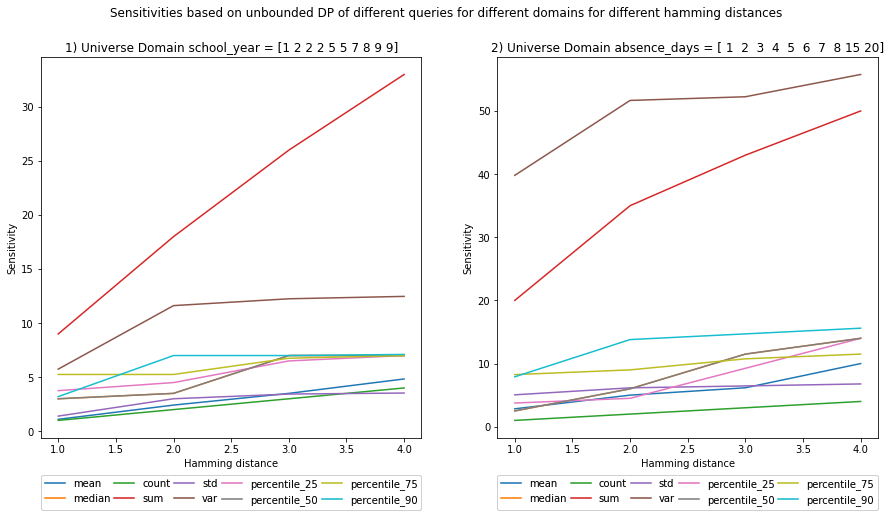

''

In [26]:
plt.figure(figsize=(15, 7))
 
query_types = ['mean', 'median', 'count', 'sum', 'std', 'var', 'percentile_25', 'percentile_50', 'percentile_75', 'percentile_90']

x_values = []
for key in unbounded_sensitivities.keys():
    
    x_values.append(key)
    
for inedx_column, column in enumerate(columns):
    
    # Start the plot
    plot_index = int(str(1) + str(len(columns)) + str(inedx_column+1))
    plt.subplot(plot_index)
    
    query_type_legend_handles = []
    for query_type in query_types:
        
        y_values = []
        for hamming_distance in unbounded_sensitivities.keys():
                           
            y_values.append(unbounded_sensitivities[hamming_distance][query_type][column])   
            
        # plot the sensitivities
        legend_handle, = plt.plot(x_values, y_values, label=query_type)
        query_type_legend_handles.append(legend_handle)
        
    # Legends
    legend = plt.legend(handles=query_type_legend_handles, bbox_to_anchor=(0., -0.2, 1., .102), \
                        ncol=5, mode="expand", borderaxespad=0.)
    ax = plt.gca().add_artist(legend)
    
    # axis labels and titles
    plt.xlabel('Hamming distance')
    plt.ylabel('Sensitivity')
    plt.title('{}) Universe Domain {} = {}'.format(inedx_column+1, column, D_a_large_universe[column].values))

plt.suptitle('Sensitivities based on unbounded DP of different queries for different domains for different hamming distances')
plt.show()
;

### Bounded sensitivity - Scenario a

Let us begin with the small dataset and a hamming distance of 1 (the only one it allows given the shapes of the release and universe dataset)

In [27]:
D_a_small_release

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Pat,3,3


In [28]:
D_a_small_universe

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Pat,3,3
3,Terry,4,10


In [29]:
np.percentile((1, 2), 90)

1.9

In [30]:
columns = ['school_year', 'absence_days']
hamming_distance = 1
bounded_sensitivities = {}
calculate_bounded_sensitivities(D_a_small_universe, D_a_small_release.shape[0], columns, hamming_distance, bounded_sensitivities)
;

Bounded sensitivities for mean {'school_year': 1.0, 'absence_days': 3.0}
Bounded sensitivities for median {'school_year': 1.0, 'absence_days': 1.0}
Bounded sensitivities for count {'school_year': 0, 'absence_days': 0}
Bounded sensitivities for sum {'school_year': 3, 'absence_days': 9}
Bounded sensitivities for std {'school_year': 0.430722547996921, 'absence_days': 3.2111854102704642}
Bounded sensitivities for var {'school_year': 0.8888888888888887, 'absence_days': 15.555555555555555}
Bounded sensitivities for percentile 25 {'school_year': 1.0, 'absence_days': 1.0}
Bounded sensitivities for percentile 50 {'school_year': 1.0, 'absence_days': 1.0}
Bounded sensitivities for percentile 75 {'school_year': 1.0, 'absence_days': 4.0}
Bounded sensitivities for percentile 90 {'school_year': 0.9999999999999996, 'absence_days': 5.799999999999999}


''

My function works as intended for the benchmark dataset. The results for mean and median are the same as in the paper.  The paper does not deal with other types of queries. (We also get the percentile 50 to cross-check with the median)

Let us continue with the large dataset and a hamming distance of 1. Also, we will create a dictionary to save the sensitivity values with the hamming distances as keys.

In [31]:
D_a_large_universe

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Keny,2,3
3,Sherry,2,4
4,Jerry,5,5
5,Morty,5,6
6,Beth,7,7
7,Summer,8,8
8,Squanchy,9,15
9,Rick,9,20


In [32]:
D_a_large_release

,name,school_year,absence_days
0,Chris,1,1
1,Kelly,2,2
2,Keny,2,3
3,Sherry,2,4
4,Jerry,5,5
5,Morty,5,6


In [33]:
columns = ['school_year', 'absence_days']
hamming_distances = [1, 2, 3, 4]
bounded_sensitivities = {}

for hamming_distance in hamming_distances:
    
    print('Hamming distance = ', hamming_distance)
    bounded_sensitivities = calculate_bounded_sensitivities(D_a_large_universe, D_a_large_release.shape[0], columns, hamming_distance, bounded_sensitivities)
    

Hamming distance =  1
Bounded sensitivities for mean {'school_year': 1.333333333333334, 'absence_days': 3.166666666666667}
Bounded sensitivities for median {'school_year': 3.0, 'absence_days': 2.5}
Bounded sensitivities for count {'school_year': 0, 'absence_days': 0}
Bounded sensitivities for sum {'school_year': 8, 'absence_days': 19}
Bounded sensitivities for std {'school_year': 1.1814550849669505, 'absence_days': 4.757896452763675}
Bounded sensitivities for var {'school_year': 5.333333333333332, 'absence_days': 38.8888888888889}
Bounded sensitivities for percentile 25 {'school_year': 2.75, 'absence_days': 3.25}
Bounded sensitivities for percentile 50 {'school_year': 3.0, 'absence_days': 2.5}
Bounded sensitivities for percentile 75 {'school_year': 3.75, 'absence_days': 7.75}
Bounded sensitivities for percentile 90 {'school_year': 2.0, 'absence_days': 7.5}
Hamming distance =  2
Bounded sensitivities for mean {'school_year': 2.5000000000000004, 'absence_days': 5.333333333333334}
Bounded

### Visualization

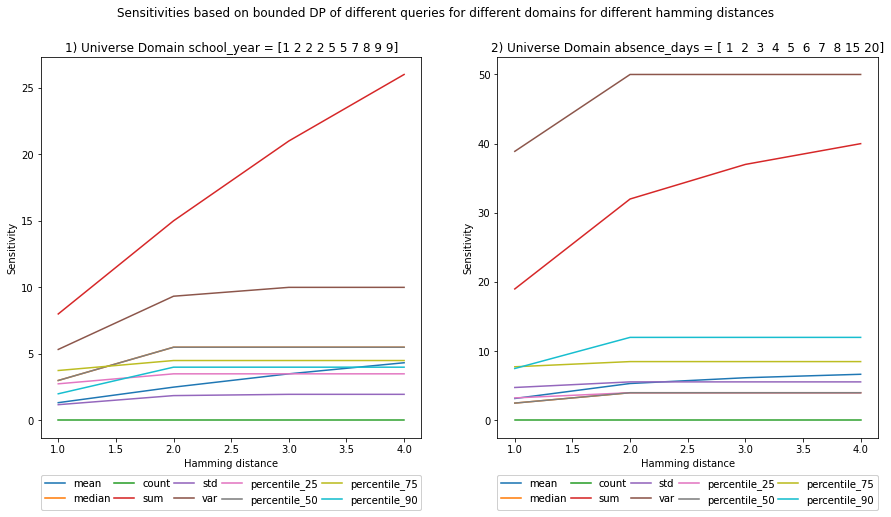

''

In [34]:
plt.figure(figsize=(15, 7))
 
query_types = ['mean', 'median', 'count', 'sum', 'std', 'var', 'percentile_25', 'percentile_50', 'percentile_75', 'percentile_90']

x_values = []
for key in bounded_sensitivities.keys():
    
    x_values.append(key)
    
for inedx_column, column in enumerate(columns):
    
    # Start the plot
    plot_index = int(str(1) + str(len(columns)) + str(inedx_column+1))
    plt.subplot(plot_index)
    
    query_type_legend_handles = []
    for query_type in query_types:
        
        y_values = []
        for hamming_distance in bounded_sensitivities.keys():
                           
            y_values.append(bounded_sensitivities[hamming_distance][query_type][column])   
            
        # plot the sensitivities
        legend_handle, = plt.plot(x_values, y_values, label=query_type)
        query_type_legend_handles.append(legend_handle)
        
    # Legends
    legend = plt.legend(handles=query_type_legend_handles, bbox_to_anchor=(0., -0.2, 1., .102), \
                        ncol=5, mode="expand", borderaxespad=0.)
    ax = plt.gca().add_artist(legend)
    
    # axis labels and titles
    plt.xlabel('Hamming distance')
    plt.ylabel('Sensitivity')
    plt.title('{}) Universe Domain {} = {}'.format(inedx_column+1, column, D_a_large_universe[column].values))

plt.suptitle('Sensitivities based on bounded DP of different queries for different domains for different hamming distances')
plt.show()
;

We can see that he values are in general smaller in comparison with the unbounded sensitivity. We can also see, that while in the unbounded sensitivity the values keep rising with the hamming distance, in bounded sensitivity they plateau. 

### Unbounded sensitivity - Scenario b

For scenario b, we have one dataset consisting of ranges of possible values. These ranges are bounded by the max and min of the previous datasets.

In [35]:
print('Cardinality of the release dataset', D_b_release_length)
print('Universe:')
D_b_universe

Cardinality of the release dataset 4
Universe:


{'mood': [1, 2, 1, 2, 1, 2, 1, 2],
 'driving_proficiency': [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]}

You have to be mindful that for these particular universes, you could use different hamming distances, as the number of elements varies between your columns. In this case we would stick with the most restrictive column and use the same hamming distances as in the previous experiments.

In [36]:
columns = ['mood', 'driving_proficiency']

hamming_distances = [1, 2, 3]
unbounded_sensitivities = {}

for hamming_distance in hamming_distances:
    
    print('Hamming distance = ', hamming_distance)
    unbounded_sensitivities = calculate_unbounded_sensitivities(D_b_universe, D_b_release_length, columns, hamming_distance, unbounded_sensitivities)
    

Hamming distance =  1
Unbounded sensitivities for mean {'mood': 0.25, 'driving_proficiency': 0.5}
Unbounded sensitivities for median {'mood': 0.5, 'driving_proficiency': 1.0}
Unbounded sensitivities for count {'mood': 1, 'driving_proficiency': 1}
Unbounded sensitivities for sum {'mood': 2, 'driving_proficiency': 3}
Unbounded sensitivities for std {'mood': 0.4330127018922193, 'driving_proficiency': 0.8660254037844386}
Unbounded sensitivities for var {'mood': 0.1875, 'driving_proficiency': 0.75}
Unbounded sensitivities for percentile 25 {'mood': 0.75, 'driving_proficiency': 1.5}
Unbounded sensitivities for percentile 50 {'mood': 0.5, 'driving_proficiency': 1.0}
Unbounded sensitivities for percentile 75 {'mood': 0.75, 'driving_proficiency': 1.5}
Unbounded sensitivities for percentile 90 {'mood': 0.7000000000000002, 'driving_proficiency': 1.4000000000000004}
Hamming distance =  2
Unbounded sensitivities for mean {'mood': 0.5, 'driving_proficiency': 1.0}
Unbounded sensitivities for median {

### Visualization

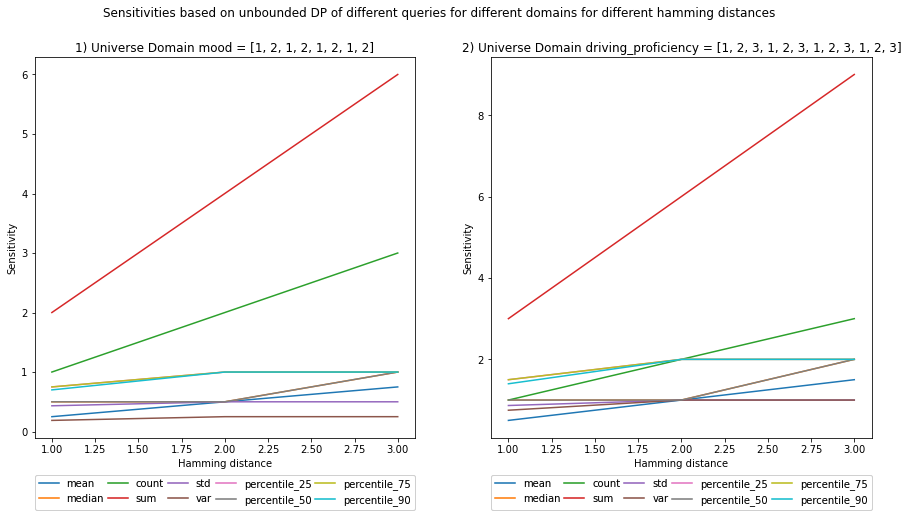

''

In [37]:
plt.figure(figsize=(15, 7))
 
query_types = ['mean', 'median', 'count', 'sum', 'std', 'var', 'percentile_25', 'percentile_50', 'percentile_75', 'percentile_90']

x_values = []
for key in unbounded_sensitivities.keys():
    
    x_values.append(key)
    
for inedx_column, column in enumerate(columns):
    
    # Start the plot
    plot_index = int(str(1) + str(len(columns)) + str(inedx_column+1))
    plt.subplot(plot_index)
    
    query_type_legend_handles = []
    for query_type in query_types:
        
        y_values = []
        for hamming_distance in unbounded_sensitivities.keys():
                           
            y_values.append(unbounded_sensitivities[hamming_distance][query_type][column])   
            
        # plot the sensitivities
        legend_handle, = plt.plot(x_values, y_values, label=query_type)
        query_type_legend_handles.append(legend_handle)
        
    # Legends
    legend = plt.legend(handles=query_type_legend_handles, bbox_to_anchor=(0., -0.2, 1., .102), \
                        ncol=5, mode="expand", borderaxespad=0.)
    ax = plt.gca().add_artist(legend)
    
    # axis labels and titles
    plt.xlabel('Hamming distance')
    plt.ylabel('Sensitivity')
    plt.title('{}) Universe Domain {} = {}'.format(inedx_column+1, column, D_b_universe[column]))

plt.suptitle('Sensitivities based on unbounded DP of different queries for different domains for different hamming distances')
plt.show()
;

### Bounded sensitivity - Scenario b

This last iteration lasts for too long. Do not run it, I did it for you.

In [38]:
D_b_universe 

{'mood': [1, 2, 1, 2, 1, 2, 1, 2],
 'driving_proficiency': [1, 2, 3, 1, 2, 3, 1, 2, 3, 1, 2, 3]}

In [39]:
columns = ['mood', 'driving_proficiency']
hamming_distances = [1, 2, 3]
bounded_sensitivities = {}

for hamming_distance in hamming_distances:
    
    print('Hamming distance = ', hamming_distance)
    bounded_sensitivities = calculate_bounded_sensitivities(D_b_universe, D_b_release_length, columns, hamming_distance, bounded_sensitivities)
    

Hamming distance =  1
Bounded sensitivities for mean {'mood': 0.25, 'driving_proficiency': 0.5}
Bounded sensitivities for median {'mood': 0.5, 'driving_proficiency': 1.0}
Bounded sensitivities for count {'mood': 0, 'driving_proficiency': 0}
Bounded sensitivities for sum {'mood': 1, 'driving_proficiency': 2}
Bounded sensitivities for std {'mood': 0.4330127018922193, 'driving_proficiency': 0.8660254037844386}
Bounded sensitivities for var {'mood': 0.1875, 'driving_proficiency': 0.75}
Bounded sensitivities for percentile 25 {'mood': 0.75, 'driving_proficiency': 1.5}
Bounded sensitivities for percentile 50 {'mood': 0.5, 'driving_proficiency': 1.0}
Bounded sensitivities for percentile 75 {'mood': 0.75, 'driving_proficiency': 1.5}
Bounded sensitivities for percentile 90 {'mood': 0.7000000000000002, 'driving_proficiency': 1.4000000000000004}
Hamming distance =  2
Bounded sensitivities for mean {'mood': 0.5, 'driving_proficiency': 1.0}
Bounded sensitivities for median {'mood': 1.0, 'driving_pr

### Visualization

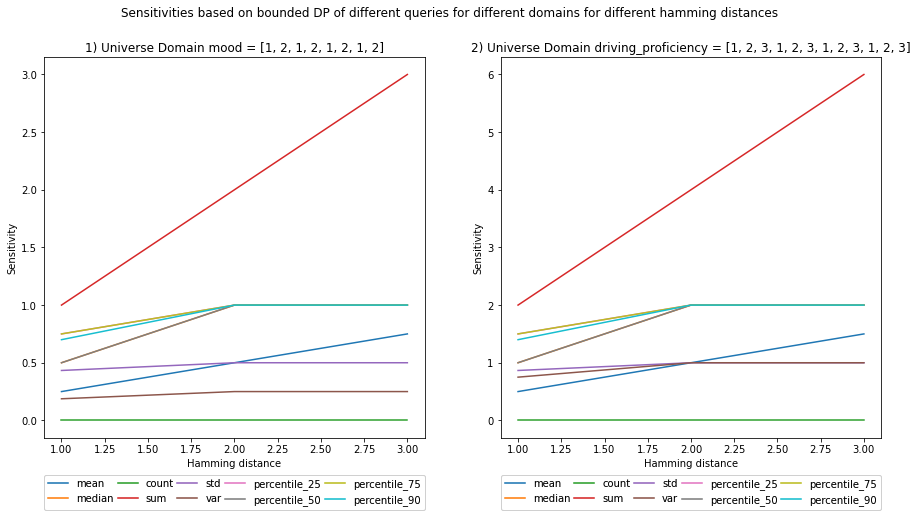

''

In [40]:
plt.figure(figsize=(15, 7))
 
query_types = ['mean', 'median', 'count', 'sum', 'std', 'var', 'percentile_25', 'percentile_50', 'percentile_75', 'percentile_90']

x_values = []
for key in bounded_sensitivities.keys():
    
    x_values.append(key)
    
for inedx_column, column in enumerate(columns):
    
    # Start the plot
    plot_index = int(str(1) + str(len(columns)) + str(inedx_column+1))
    plt.subplot(plot_index)
    
    query_type_legend_handles = []
    for query_type in query_types:
        
        y_values = []
        for hamming_distance in bounded_sensitivities.keys():
                           
            y_values.append(bounded_sensitivities[hamming_distance][query_type][column])   
            
        # plot the sensitivities
        legend_handle, = plt.plot(x_values, y_values, label=query_type)
        query_type_legend_handles.append(legend_handle)
        
    # Legends
    legend = plt.legend(handles=query_type_legend_handles, bbox_to_anchor=(0., -0.2, 1., .102), \
                        ncol=5, mode="expand", borderaxespad=0.)
    ax = plt.gca().add_artist(legend)
    
    # axis labels and titles
    plt.xlabel('Hamming distance')
    plt.ylabel('Sensitivity')
    plt.title('{}) Universe Domain {} = {}'.format(inedx_column+1, column, D_b_universe[column]))

plt.suptitle('Sensitivities based on bounded DP of different queries for different domains for different hamming distances')
plt.show()
;